In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, scale
import numpy as np
from sklearn.neural_network import MLPRegressor

sns.set(style="whitegrid")

__Section 1: Import data__

In [2]:
# UNHCR DATA
unhcr = pd.read_csv("unhcr_popstats_export_asylum_seekers_monthly_all_data.csv", skiprows=3)
unhcr['Value'] = pd.to_numeric(unhcr['Value'], errors='coerce', downcast='integer')
unhcr = unhcr.dropna(subset=['Value'])
unhcr = unhcr.rename(columns={"Country / territory of asylum/residence":"destination","Origin":"origin","Year":"year","Month":"month","Value":"num_migrants"})


/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# ACLED data

acled_raw = pd.read_csv("1990-01-01-2018-12-31.csv")
acled = acled_raw[['year','event_type','country','fatalities']]

In [4]:
# UN Population data
# population is in thousands

population_raw = pd.read_csv("WPP2017_TotalPopulationBySex.csv")
population = population_raw[(population_raw['Variant'] == "Medium") & (population_raw["Time"] >= 1990) & (population_raw["Time"] <= 2017)][['Location','Time','PopTotal']].sort_values(['Location','Time'])

In [5]:
# food data

food_raw = pd.read_csv("wfpvam_foodprices.csv")
food = food_raw[food_raw['cm_name'] == "Bread - Retail"]
#food['maximum_breadprice'] = food.groupby(['adm0_name','mp_year']).aggregate({"mp_price":"max"}).reset_index()
food = food.groupby(['adm0_name','mp_year']).aggregate({"mp_price":"max"}).reset_index().rename(columns={"mp_price":"max_breadprice","adm0_name":"country","mp_year":"year"})

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# cpi data
cpi_raw = pd.read_csv("API_FP.CPI.TOTL_DS2_en_csv_v2_10473726.csv", skiprows=4)
cpi_raw = cpi_raw.drop(['Indicator Name','Country Code','Indicator Code'], axis=1)
cpi = pd.melt(cpi_raw, id_vars='Country Name').rename(columns={"Country Name":"country","variable":"year","value":"cpi_index"}).dropna(subset=['cpi_index'])
cpi['year'] = cpi['year'].astype(int)


In [7]:
# gdp per capita data

gdp_raw = pd.read_csv("API_NY.GDP.PCAP.PP.CD_DS2_en_csv_v2_10473683.csv", skiprows=4)
gdp_raw = gdp_raw.drop(['Indicator Name','Country Code','Indicator Code'], axis=1)
gdp_temp = pd.melt(gdp_raw, id_vars='Country Name').rename(columns={"Country Name":"country","variable":"year","value":"gdp_per_capita"})
gdp = gdp_temp[(gdp_temp['year'] != "Unnamed: 63")]
gdp['year'] = gdp['year'].astype(int)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [8]:
###### reconciling country names

acled_words = pd.DataFrame({"country":acled['country'].unique()})
population_words = pd.DataFrame({"country":population['Location'].unique()})
unhcr_words = pd.DataFrame({"country":unhcr['origin'].unique()})
gdp_words = pd.DataFrame({"country":gdp['country'].unique()})

# merge country names to get an idea of what doesn't match
merge_1 = acled_words.merge(unhcr_words, on="country", indicator=True, how="outer").rename(columns={"_merge":"_merge1"})
merge_2 = merge_1.merge(population_words, on="country", indicator=True, how="outer").rename(columns={"_merge":"_merge2"})
merge_3 = merge_2.merge(gdp_words, on="country", indicator=True, how="outer").rename(columns={"_merge":"_merge3"})

unmatched_names = merge_3[(merge_3["_merge3"] != "both") | (merge_3["_merge2"] != "both") | (merge_3["_merge1"] != "both")]
unmatched_names_only = unmatched_names[["country","_merge1","_merge2","_merge3"]].sort_values('country')
unmatched_names_only.to_csv("unmatched_names.csv")

In [9]:
rematch = {
"American Samoa":"Samoa",
"Bahamas, The":"Bahamas",
"Bolivia (Plurinational State of)":"Bolivia",
"Bosnia-Herzegovina":"Bosnia and Herzegovina",
"Cambodia (Kampuchea)":"Cambodia",
"Central African Rep.":"Central African Republic",
"China, Hong Kong SAR":"Hong Kong",
"Hong Kong SAR, China":"Hong Kong",
"Iran (Islamic Rep. of)":"Iran",
"Iran (Islamic Republic of)":"Iran",
"Iran, Islamic Rep.":"Iran",
"Cote d'Ivoire":"Ivory Coast",
"Côte d'Ivoire":"Ivory Coast",
"Kyrgyz Republic":"Kyrgyzstan",
"Lao PDR":"Laos",
"Lao People's Dem. Rep.":"Laos",
"Lao People's Democratic Republic":"Laos",
"Macao SAR, China":"Macao",
"China, Macao SAR":"Macao",
"TFYR Macedonia":"Macedonia",
"The former Yugoslav Rep. of Macedonia":"Macedonia",
"Macedonia, FYR":"Macedonia",
"Micronesia (Fed. States of)":"Micronesia",
"Micronesia (Federated States of)":"Micronesia",
"Micronesia, Fed. Sts.":"Micronesia",
"Rep. of Moldova":"Moldova",
"Republic of Moldova":"Moldova",
"Rep. of Korea":"South Korea",
"Republic of Korea":"South Korea",
"Korea, Dem. People’s Rep.":"North Korea",
"Korea, Rep.":"South Korea",
"Dem. People's Rep. of Korea":"North Korea",
"Dem. People's Republic of Korea":"North Korea",
"Yemen (North Yemen)":"Yemen",
"Yemen, Rep.":"Yemen",
"Viet Nam":"Vietnam",
"Venezuela (Bolivarian Republic of)":"Venezuela",
"Venezuela, RB":"Venezuela",
"United States of America":"United States",
"United Rep. of Tanzania":"Tanzania",
"United Republic of Tanzania":"Tanzania",
"United Kingdom of Great Britain and Northern Ireland":"United Kingdom",
"Syrian Arab Rep.":"Syria",
"Syrian Arab Republic":"Syria",
"Serbia (Yugoslavia)":"Serbia",
"Russia (Soviet Union)":"Russia",
"Russian Federation":"Russia",
"Rumania":"Romania",
"Palestinian":"Palestine",
"State of Palestine":"Palestine",
"Myanmar (Burma)":"Myanmar",
"india":"India",
"iraq":"Iraq",
"eSwatini":"Swaziland",
"Occupied Palestinian Territories":"Palestine",
"Occupied Palestinian Territory":"Palestine",
"Gambia, The":"Gambia",
"Egypt, Arab Rep.":"Egypt",
"Iran, Islamic Rep.":"Iran",
"Yemen, Rep.":"Yemen",

}

# to combine:
acled['country'] = acled['country'].replace(rematch)
population['Location'] = population['Location'].replace(rematch)
unhcr['origin'] = unhcr['origin'].replace(rematch)
gdp['country'] = gdp['country'].replace(rematch)
cpi['country'] = cpi['country'].replace(rematch)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
unhcr_since_1990 = unhcr[unhcr.year >= 1990]

__Since 2015: Number of countries of origin__

In [11]:
len(unhcr_since_1990['origin'].unique())

205

__Since 2015: Number of destination countries__

In [12]:
len(unhcr_since_1990['destination'].unique())

45

__Since 1990: Average monthly arrivals per country__

In [13]:
monthly_arrivals_since_1990 = unhcr_since_1990.groupby(['destination','year','month'])['num_migrants'].sum().reset_index()
average_monthly_arrivals_since_1990 = monthly_arrivals_since_1990.groupby(['destination']).aggregate({'num_migrants':'mean'}).reset_index()


__Since 1990: Average monthly departures per country__

In [14]:
monthly_departures_since_1990 = unhcr_since_1990.groupby(['origin','year','month'])['num_migrants'].sum().reset_index()
average_monthly_departures_since_1990 = monthly_departures_since_1990.groupby(['origin']).aggregate({'num_migrants':'mean'}).reset_index()

In [15]:
average_monthly_arrivals_since_1990 = average_monthly_arrivals_since_1990.sort_values('num_migrants', ascending=False)
average_monthly_departures_since_1990 = average_monthly_departures_since_1990.sort_values('num_migrants', ascending=False)

__Creating new datasets for use with ML analysis__

In [17]:
# plots

# distribution of destination countries by origin country and year
destination_distributions = unhcr_since_1990.groupby(["origin","year","destination"]).aggregate({"num_migrants":sum}).reset_index()
destination_distributions['dist_num_migrants'] = destination_distributions.groupby(['origin','year']).transform(lambda x: x / sum(x))
#destination_distributions

# total departures by year
departures_by_year = unhcr_since_1990.groupby(["origin","year"]).aggregate({"num_migrants":sum}).reset_index()




In [18]:
departures_by_year['sum_5year'] = departures_by_year.groupby(["origin"]).num_migrants.rolling(window=5, win_type='boxcar', center=False).sum().reset_index()['num_migrants'].shift(-4)
departures_by_year['sum_3year'] = departures_by_year.groupby(["origin"]).num_migrants.rolling(window=3, win_type='boxcar', center=False).sum().reset_index()['num_migrants'].shift(-2)
departures_by_year['sum_2year'] = departures_by_year.groupby(["origin"]).num_migrants.rolling(window=2, win_type='boxcar', center=False).sum().reset_index()['num_migrants'].shift(-1)

departures_by_year['asylumseekers_previous_year'] = departures_by_year.groupby(["origin"])['num_migrants'].apply(lambda x: x.shift(1)).fillna(0)


In [19]:
# number of events by type

acled_event_types_by_year = acled.groupby(['country','year','event_type']).count().reset_index().rename(columns={"fatalities":"event_count"})
acled_event_types_by_year['event_type'] = "event_type " + acled_event_types_by_year['event_type'].astype(str)
acled_event_types_by_year_wide = acled_event_types_by_year.pivot_table(index=['country','year'], values="event_count", columns="event_type", fill_value=0).reset_index()



In [20]:
# add count here as well
acled_by_year = acled.groupby(['country','year'])['fatalities'].agg({'total_fatalities':'sum','event_count':'count'}).reset_index()
acled_by_year_w_event_count = acled_by_year.merge(acled_event_types_by_year_wide, on=['country','year'])

# ROUGH MERGE
acled_population = acled_by_year_w_event_count.merge(population, left_on=["country","year"], right_on=["Location","Time"], how="inner")
unhcr_acled_population_temp = acled_population.merge(departures_by_year, left_on=["country","year"], right_on=["origin","year"], how="inner")
unhcr_acled_population_temp2 = unhcr_acled_population_temp.merge(gdp, left_on=["country","year"], right_on=["country","year"], how="inner")
unhcr_acled_population = unhcr_acled_population_temp2.merge(cpi, left_on=["country","year"], right_on=["country","year"], how="inner")



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [21]:
unhcr_acled_population['country'].unique()

array(['Afghanistan', 'Algeria', 'Angola', 'Bahrain', 'Bangladesh',
       'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cambodia',
       'Cameroon', 'Central African Republic', 'Chad', 'Djibouti',
       'Egypt', 'Equatorial Guinea', 'Ethiopia', 'Gabon', 'Gambia',
       'Ghana', 'Guinea', 'Guinea-Bissau', 'India', 'Indonesia', 'Iran',
       'Iraq', 'Israel', 'Ivory Coast', 'Jordan', 'Kenya', 'Kuwait',
       'Laos', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Madagascar',
       'Malawi', 'Mali', 'Mauritania', 'Morocco', 'Myanmar', 'Namibia',
       'Nepal', 'Niger', 'Nigeria', 'Oman', 'Pakistan', 'Philippines',
       'Rwanda', 'Saudi Arabia', 'Senegal', 'Sierra Leone',
       'South Africa', 'South Sudan', 'Sri Lanka', 'Sudan', 'Tanzania',
       'Thailand', 'Togo', 'Tunisia', 'Turkey', 'Uganda',
       'United Arab Emirates', 'Vietnam', 'Zambia', 'Zimbabwe'],
      dtype=object)

__Create new features__

In [22]:
unhcr_acled_population = unhcr_acled_population.dropna(subset=['gdp_per_capita'])

# fill sum5year nas with current year number
unhcr_acled_population = unhcr_acled_population.dropna(subset=['sum_5year'])

unhcr_acled_population['percent_migrants'] = unhcr_acled_population['num_migrants'] / (unhcr_acled_population['PopTotal']*1000)
unhcr_acled_population['percent_5year'] = unhcr_acled_population['sum_5year'] / (unhcr_acled_population['PopTotal']*1000)
unhcr_acled_population['percent_fatalities'] = unhcr_acled_population['total_fatalities'] / (unhcr_acled_population['PopTotal']*1000)
unhcr_acled_population['log_poptotal'] = np.log(unhcr_acled_population['PopTotal']*1000)
unhcr_acled_population['conflict_previous_year'] =  unhcr_acled_population.groupby(["country"])['year'].apply(lambda x: x.shift(1) == x - 1)
unhcr_acled_population['events_per_1000_population'] = unhcr_acled_population['event_count'] / unhcr_acled_population['PopTotal']
unhcr_acled_population['poptotal_exact'] = unhcr_acled_population['PopTotal']*1000

# add fatality difference since previous year
unhcr_acled_population['percent_fatality_increase'] =  unhcr_acled_population.sort_values(['country','year']).groupby(["country"])['total_fatalities'].apply(lambda x: (x - x.shift(1)) / x.shift(1)).fillna(1).replace(np.inf, 0)
unhcr_acled_population['absolute_fatality_change'] =  unhcr_acled_population.sort_values(['country','year']).groupby(["country"])['total_fatalities'].apply(lambda x: x - x.shift(1)).fillna(1).replace(np.inf, 0)

# number of event difference since previous year
unhcr_acled_population['num_event_change'] =  unhcr_acled_population.sort_values(['country','year']).groupby(["country"])['event_count'].apply(lambda x: x - x.shift(1)).fillna(0).replace(np.inf, 0)

# cpi percent change since previous year
unhcr_acled_population['cpi_change'] =  unhcr_acled_population.sort_values(['country','year']).groupby(["country"])['cpi_index'].apply(lambda x: x - x.shift(1)).fillna(0).replace(np.inf, 0)


unhcr_acled_population['log_num_migrants'] = np.log(unhcr_acled_population['num_migrants'])
unhcr_acled_population['squared_civilian_violence'] = (unhcr_acled_population['event_type Violence against civilians'])^2

# consecutive previous years of conflict. not apparently useful
unhcr_acled_population['consec_yrs_conflict'] = unhcr_acled_population.groupby(["country"])['conflict_previous_year'].cumsum() - unhcr_acled_population.groupby(["country"])['conflict_previous_year'].cumsum().where(~unhcr_acled_population['conflict_previous_year']).ffill()
unhcr_acled_population['morethan3yrs_conflict'] = (unhcr_acled_population['consec_yrs_conflict'] > 3)

del unhcr_acled_population['conflict_previous_year']



__Setup ML pipeline__

In [24]:
# all variables in one csv for use in R, Stata, etc.
unhcr_acled_population.to_csv("allvars.csv", encoding="utf-8", index=False)

In [214]:
# set holdout country - we don't use any years from this country in the training or testing!
holdout_country = "Myanmar"
holdout_country_indices = unhcr_acled_population.loc[unhcr_acled_population['country'] == holdout_country].index

unhcr_acled_population_to_use = unhcr_acled_population[unhcr_acled_population['country'] != holdout_country]

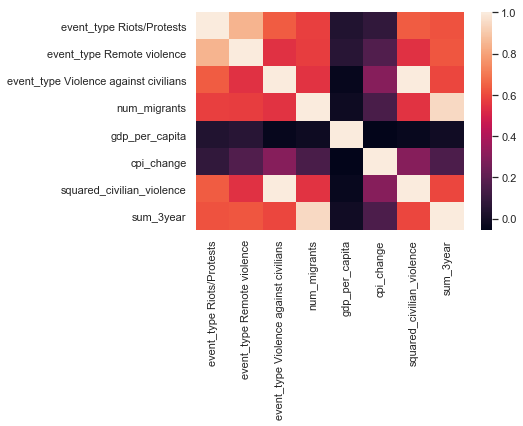

In [215]:
# this is where we choose feature and outcome variables
'''feature_variables = ['poptotal_exact','total_fatalities','event_count','consec_yrs_conflict']
feature_variables = ['poptotal_exact','total_fatalities',
'event_type Battle-Government regains territory',
'event_type Battle-No change of territory',
'event_type Battle-Non-state actor overtakes territory',
'event_type Headquarters or base established',
'event_type Non-violent transfer of territory',
'event_type Remote violence', 'event_type Riots/Protests',
'event_type Violence against civilians']'''

feature_variables = ['event_type Riots/Protests','event_type Remote violence','event_type Violence against civilians','num_migrants','gdp_per_capita','cpi_change','squared_civilian_violence']
outcome_variable = ['sum_3year']

# create dummies for categorical variables
data_prelim = unhcr_acled_population_to_use[feature_variables + outcome_variable]

data_w_countries = unhcr_acled_population_to_use[feature_variables + outcome_variable + ['country','year']]
data = pd.get_dummies(data_prelim, drop_first=True)

y = data[outcome_variable]
X = data.drop(outcome_variable, axis=1)

feature_names = data.drop(outcome_variable, axis=1).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# holdout country data
holdout_country_data = unhcr_acled_population[unhcr_acled_population['country'] == holdout_country][feature_variables + outcome_variable]

# plot correlation matrix

corr = data.corr()

sns.heatmap(corr)

__Pipeline__

In [216]:
# Random Forest Regressor

# there's obviously only one step in the pipeline but it's here if we need it!
rf_pipeline_steps = [('randomforest',RandomForestRegressor())]

rf_pipeline_parameters = {#"randomforest__max_depth":np.linspace(1,12,12, dtype=int),
                        "randomforest__n_estimators":np.linspace(10,100, dtype=int)
                       }

rf_pipeline = Pipeline(rf_pipeline_steps)


rf_fit_cv = GridSearchCV(rf_pipeline, rf_pipeline_parameters)

rf_fit_cv.fit(X_train.values, y_train.values.ravel())

# assess model fit

rf_r2 = rf_fit_cv.score(X_test.values, y_test.values.ravel())
rf_r2

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.8556433741687183

In [217]:
fit_cv = rf_fit_cv

# more model fit -- now on holdout data!
X_test_frame = pd.DataFrame(holdout_country_data, columns=holdout_country_data.drop(outcome_variable, axis=1).columns)
X_test_frame['y_predicted'] = fit_cv.predict(X_test_frame.values)
X_test_frame['y_actual'] = holdout_country_data['sum_3year']
X_test_frame['country'] = unhcr_acled_population.loc[holdout_country_indices]['country']
X_test_frame['year'] = unhcr_acled_population.loc[holdout_country_indices]['year']


In [218]:
X_test_frame

,event_type Riots/Protests,event_type Remote violence,event_type Violence against civilians,num_migrants,gdp_per_capita,cpi_change,squared_civilian_violence,y_predicted,y_actual,country,year
548,15,39,36,1561.0,3645.936435,0.000000,38,6095.626506,4651.0,Myanmar,2010
549,23,57,69,1456.0,3898.414627,5.021460,71,4881.638554,4318.0,Myanmar,2011
550,131,59,70,1634.0,4225.119352,1.541277,68,5541.879518,3863.0,Myanmar,2012
551,150,56,58,1228.0,4613.339782,5.843246,56,4068.156627,3702.0,Myanmar,2013
552,218,64,60,1001.0,5024.909112,5.672468,62,3588.831325,3754.0,Myanmar,2014


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


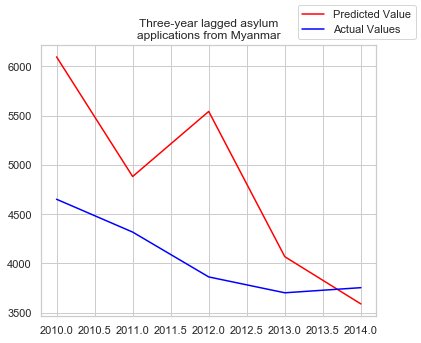

In [219]:
fig, ax = plt.subplots(figsize=(6,5))
predicted = ax.plot(X_test_frame['year'], X_test_frame['y_predicted'], color="red")
actual = ax.plot(X_test_frame['year'], X_test_frame['y_actual'], color="blue")
fig.legend(["Predicted Value","Actual Values"])
plt.title("Three-year lagged asylum\napplications from {}".format(holdout_country))
fig.show()

In [154]:
# this frame is the full randomly sampled testing set, not including the holdout country

X_test_frame_2 = pd.DataFrame(X_test, columns=X_test.columns.values)
X_test_frame_2['y_predicted'] = fit_cv.predict(X_test)
X_test_frame_2['y_actual'] = y_test
X_test_frame_2['country'] = data_w_countries.loc[X_test_frame_2.index, 'country']
X_test_frame_2['year'] = data_w_countries.loc[X_test_frame_2.index, 'year']

#X_test_frame_2['year'] = X_test.loc[holdout_country_indices]['year']
X_test_frame_2

,event_type Riots/Protests,event_type Remote violence,event_type Violence against civilians,log_num_migrants,gdp_per_capita,cpi_change,squared_civilian_violence,y_predicted,y_actual,country,year
305,23,0,19,7.973500,3940.097375,13.588208,17,9707.966667,14006.0,Ghana,2013
20,14,42,96,8.460623,3008.903942,0.000000,98,19050.933333,18607.0,Angola,1999
53,1,0,1,5.356586,1456.364545,1.162484,3,653.300000,553.0,Benin,2003
641,0,0,39,6.903747,1436.868937,3.080171,37,3373.333333,2686.0,Rwanda,2011
684,89,7,11,6.324359,8131.735924,6.011492,9,1996.800000,1446.0,South Africa,2002
448,3,0,2,6.714171,27523.817457,2.335452,0,3290.366667,5683.0,Libya,2009
805,15,0,78,6.429719,1088.685704,5.194641,76,2248.766667,1850.0,Uganda,2005
635,0,0,3,7.300473,930.892958,5.355435,1,4520.233333,3874.0,Rwanda,2005
643,5,7,5,6.741701,1610.316345,6.733971,7,2960.200000,2381.0,Rwanda,2013
501,1,2,2,7.211557,1774.065350,2.378139,0,4342.833333,6989.0,Mali,2009


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


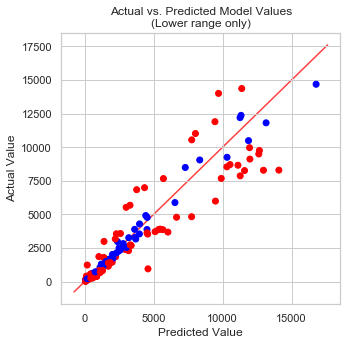

In [237]:
# plot a subset of points within a certain range
subset = X_test_frame_2[X_test_frame_2['y_actual'] < 15000]

subset.loc[abs((subset['y_predicted'] - subset['y_actual'])/subset['y_actual']) > 0.2, 'color'] = "red"
subset['color'] = subset['color'].fillna('blue')


# scatterplot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

# label outliers
#outliers = data_w_countries[data_w_countries['sum_3year'] > 0.01]

ax.scatter(subset['y_predicted'],subset['y_actual'], color=subset['color'])

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]


ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0, color="red")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.title("Actual vs. Predicted Model Values\n(Lower range only)")

plt.show()